# ML innlevering 2 - TMDB Box Office Prediction

# Getting started

# Setup

In [2097]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

import joblib
from joblib import dump
from pathlib import Path

In [2098]:
NB_DIR = Path.cwd()
DATA_DIR = NB_DIR/'...'/'data'

#### Get the data:

In [2099]:
#lists the files in the folder
import os
print(os.listdir("data"))

['test.csv', 'train.csv', 'sample_submission.csv']


In [2100]:
#Reads in the csv-files and creates a dataframe using pandas

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sampleSubmission = pd.read_csv('data/sample_submission.csv')

## Explore the data

In [2101]:
X = train
X_test = test

In [2102]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [2103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

Info gives a clean list of all the features in the train set. Most of the features are objects, except a few which are ints or floats. Info also contains info about the Non-Null numbers. Some features contains a smaller amount of Non-Null numbers, whoch means there are missing data. The column "belongs_to_collection" have a very small Non-Null so the feature probably have a lot of missing data. Lets go deeper:

The code underneath provides an overview of missing values in train. The missing values makes it harder to give good predictions, if it is not handled correctly.

In [2104]:
print(train.isnull().sum())

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64


Text(0.5, 1.0, 'Missing Value count By Features')

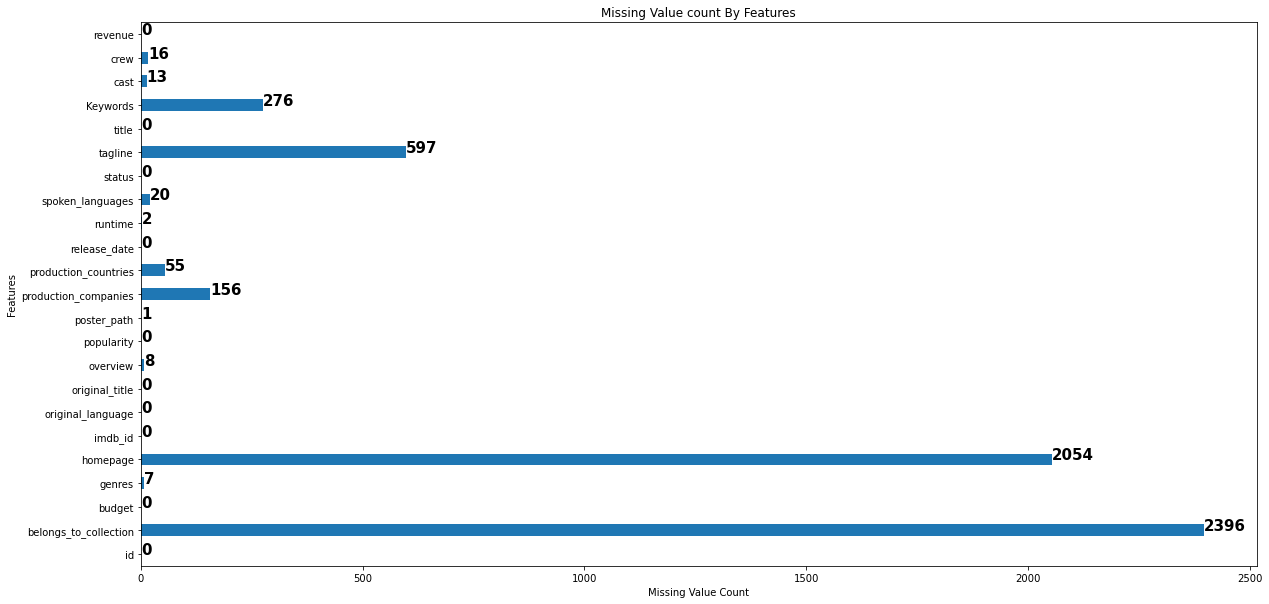

In [2105]:
train.isna().sum().plot(kind="barh", figsize=(20,10))
for i, v in enumerate(train.isna().sum()):
    plt.text(v, i, str(v), fontweight='bold', fontsize = 15)
plt.xlabel("Missing Value Count")
plt.ylabel("Features")
plt.title("Missing Value count By Features")

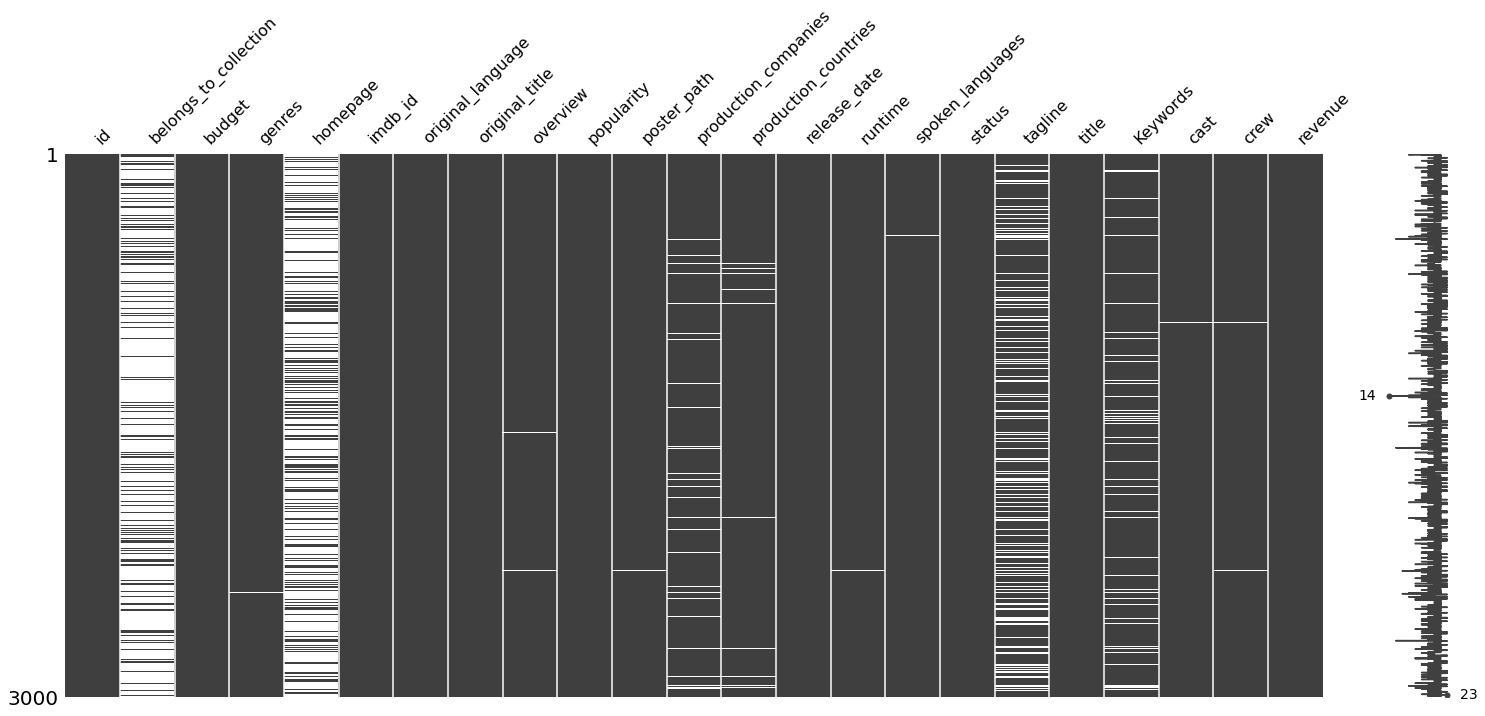

In [2106]:
import missingno as msno  
  
# Visualize missing values as a matrix 
msno.matrix(train) 

We are dropping most of the features that has missing values, and then we will keep the necessary ones and calculate the missing values

In [2107]:
X = train.drop(['id', 'homepage', 'overview', 
                'poster_path','production_companies',
                'production_countries','Keywords',
            'tagline','cast','crew'],axis=1)

Underneath is a code written to fill all "nan"´s with zeros. This is done, because the movies with nan in the feature "belongs_to_collection" most likely des not belong to any collection.

In [2108]:
X["belongs_to_collection"] = np.where(pd.notnull(X["belongs_to_collection"]), 1, 0)

In [2109]:
X.head()

,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,popularity,release_date,runtime,spoken_languages,status,title,revenue
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,Hot Tub Time Machine 2,6.575393,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hot Tub Time Machine 2,12314651
1,1,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,The Princess Diaries 2: Royal Engagement,8.248895,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Princess Diaries 2: Royal Engagement,95149435
2,0,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,Whiplash,64.299990,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Whiplash,13092000
3,0,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,Kahaani,3.174936,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Kahaani,16000000
4,0,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,마린보이,1.148070,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,Marine Boy,3923970


In [2110]:
X.describe()

,belongs_to_collection,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,0.201333,2.253133e+07,8.463274,107.856571,6.672585e+07
std,0.401063,3.702609e+07,12.104000,22.086434,1.375323e+08
min,0.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,0.000000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,0.000000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,0.000000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,1.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


If std had been 1 and mean hade been 0, it would have been a perfect result already

# Looking into the genres

In [2111]:
def fixGenres(df):

    df['genres_list'] = df['genres'].apply(lambda x: list(map(lambda d: list(d.values())[1], 
                                                       ast.literal_eval(x)) if isinstance(x, str) else ['None']))

    df['num_genres'] = df['genres_list'].apply(lambda x: len(x) if x != {} else 0)

In [2112]:
fixGenres(X_test)
X_test['num_genres'].head()

0    4
1    2
2    2
3    3
4    2
Name: num_genres, dtype: int64

In [2113]:
import ast

# from this kernel: https://www.kaggle.com/gravix/gradient-in-a-box
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train_vizu = text_to_dict(train)
test_vizu = text_to_dict(test)

In [2114]:
for i, e in enumerate(train_vizu['genres'][:5]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [2115]:
print('Number of genres in films')
train_vizu['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [2116]:
list_of_genres = list(train_vizu['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

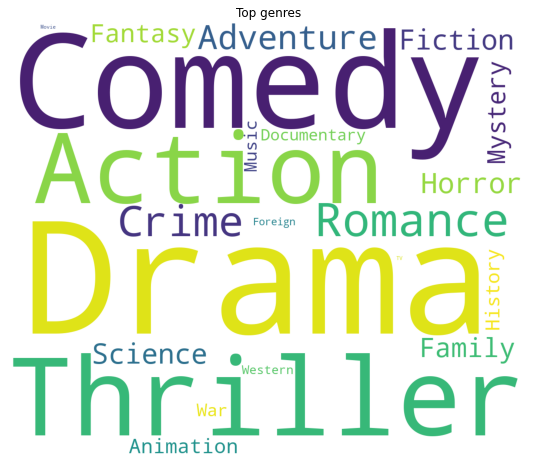

In [2117]:
from wordcloud import WordCloud 

plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                        width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

A wordcloud of top genres. Here we can see that Drama, Comedy and Thriller are popular genres.

from this kernel: https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation

### Handeling genres

In [2118]:
X['genres'].head(5)

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
3    [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
Name: genres, dtype: object

In [2119]:
fixGenres(X)
X['num_genres'].head()

0    1
1    4
2    1
3    2
4    2
Name: num_genres, dtype: int64

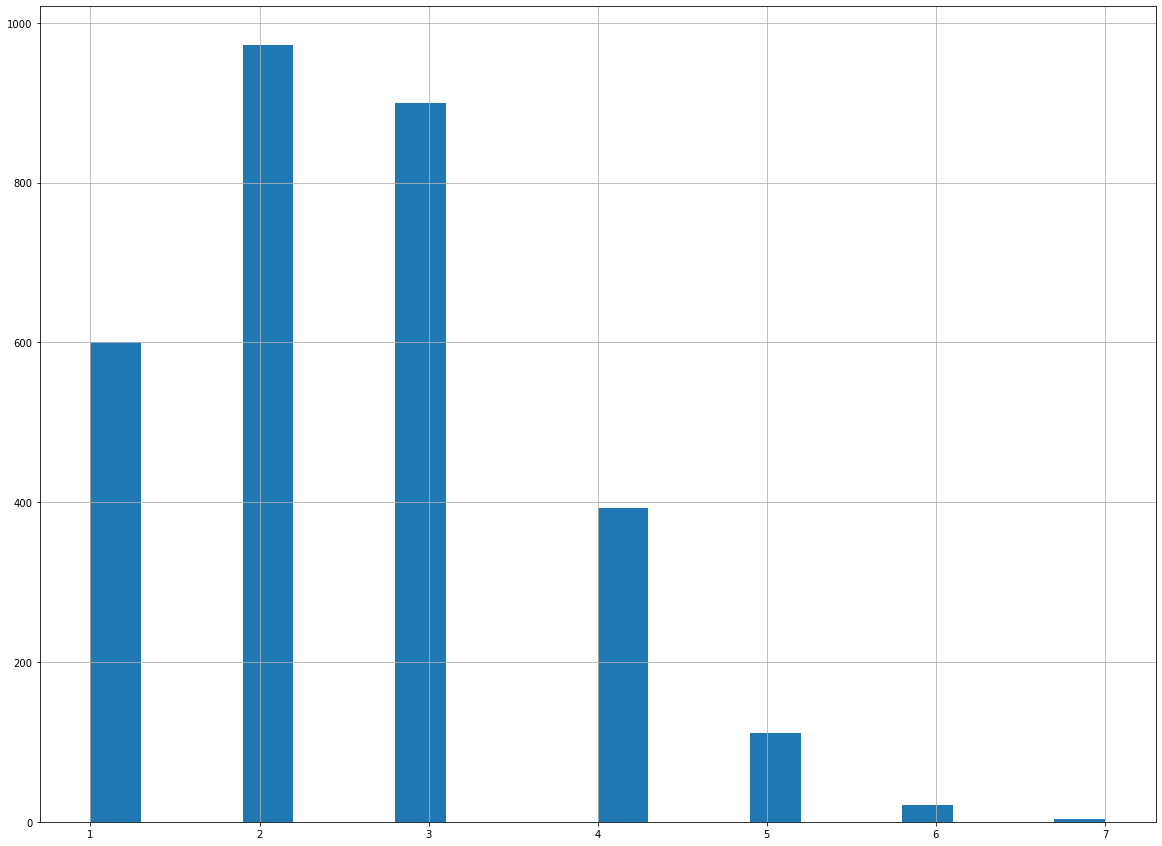

In [2120]:
X['num_genres'].hist(bins=20,figsize=(20,15))
plt.show()

In [2121]:
X_test['num_genres'].head()

0    4
1    2
2    2
3    3
4    2
Name: num_genres, dtype: int64

### Release of movies

In [2122]:
def splitDayMonthYear(df):
    #Since only last two digits of year are provided, this is the correct way of getting the year.
    df[['release_month','release_day','release_year']]=df['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
    # Some rows have 4 digits of year instead of 2, that's why I am applying (train['release_year'] < 100) this condition
    df.loc[ (df['release_year'] <= 19) & (df['release_year'] < 100), "release_year"] += 2000
    df.loc[ (df['release_year'] > 19)  & (df['release_year'] < 100), "release_year"] += 1900

    releaseDate = pd.to_datetime(df['release_date']) 
    df['release_dayofweek'] = releaseDate.dt.dayofweek

In [2123]:
splitDayMonthYear(X)

In [2124]:
X.head()

,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,popularity,release_date,runtime,spoken_languages,status,title,revenue,genres_list,num_genres,release_month,release_day,release_year,release_dayofweek
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,Hot Tub Time Machine 2,6.575393,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hot Tub Time Machine 2,12314651,[Comedy],1,2,20,2015,4
1,1,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,The Princess Diaries 2: Royal Engagement,8.248895,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Princess Diaries 2: Royal Engagement,95149435,"[Comedy, Drama, Family, Romance]",4,8,6,2004,4
2,0,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,Whiplash,64.299990,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Whiplash,13092000,[Drama],1,10,10,2014,4
3,0,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,Kahaani,3.174936,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Kahaani,16000000,"[Thriller, Drama]",2,3,9,2012,4
4,0,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,마린보이,1.148070,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,Marine Boy,3923970,"[Action, Thriller]",2,2,5,2009,3


Get Month, Day, Year and week day from release date

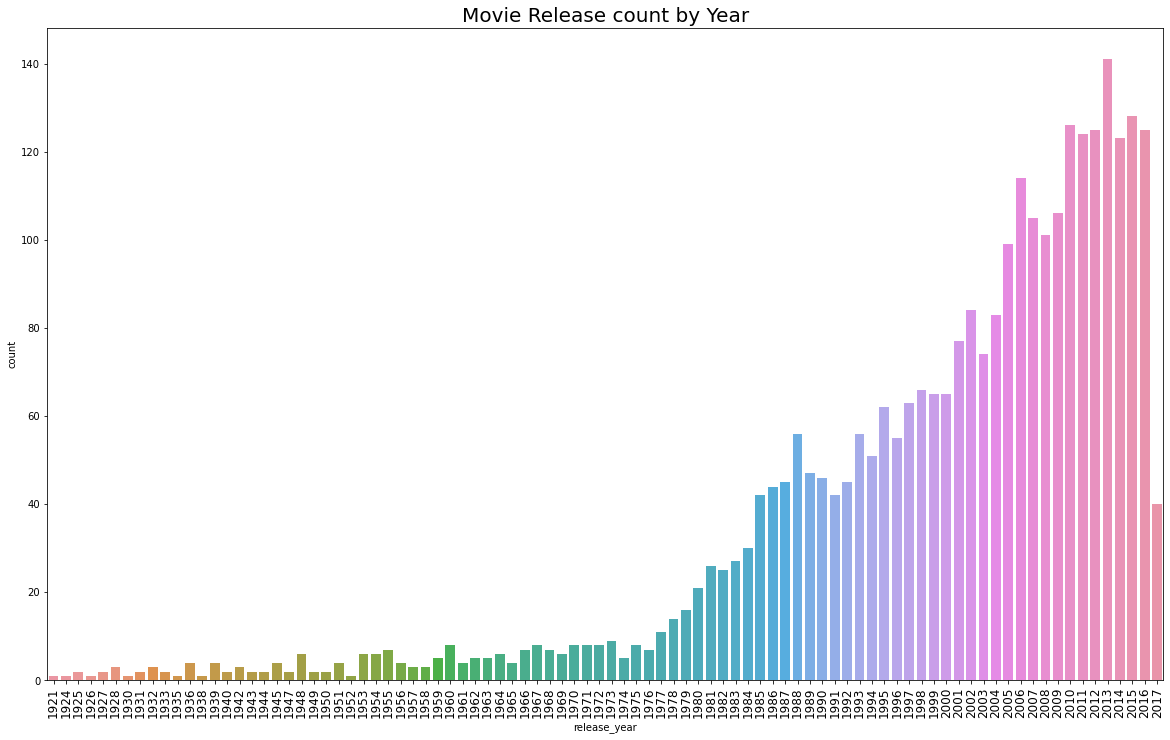

In [2125]:
import seaborn as sns

plt.figure(figsize = (20, 12))
sns.countplot(X['release_year'].sort_values())
plt.title("Movie Release count by Year", fontsize = 20)
loc, labels = plt.xticks()
plt.xticks(fontsize = 12, rotation = 90)
plt.show()

A plot of release year

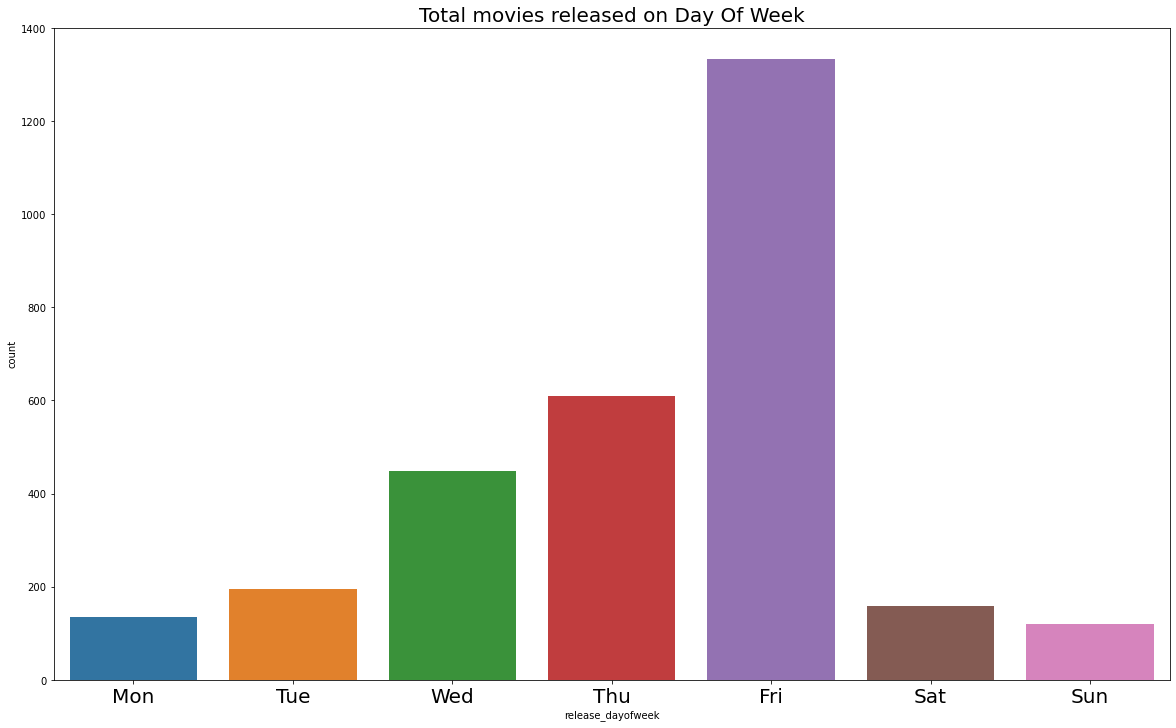

In [2126]:
plt.figure(figsize=(20,12))
sns.countplot(X['release_dayofweek'].sort_values())
plt.title("Total movies released on Day Of Week",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

A plot of release day of week

However, it is more important to know which year, than day and month. Therefore year is kept while day and month are dropped

In [2127]:
X = X.drop(['release_date','release_day', 'release_month','release_dayofweek'], axis=1)
X['release_year']=np.where(X['release_year']> 2018, X['release_year']-100, X['release_year'])

### Is the movie released?

In [2128]:
train['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

In the train data is 2996 movies released, and 4 movies are yet to release.

In [2129]:
train.loc[train['status'] == "Rumored"][['status','revenue']]

,status,revenue
609,Rumored,273644
1007,Rumored,60
1216,Rumored,13418091
1618,Rumored,229000


This is strange, movie is yet to release and revenue is already given.

In [2130]:
test['status'].value_counts()

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64

In the test data is 4389 movies released, and 7 movies are yet to release.

### Keywords in movies

In [2131]:
for i, e in enumerate(train['Keywords'][:5]):
    print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [2132]:
print('Number of Keywords in films')
train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

Here we have some keywords describing films. Of course there can be a lot of them. Let's have a look at the most common ones.

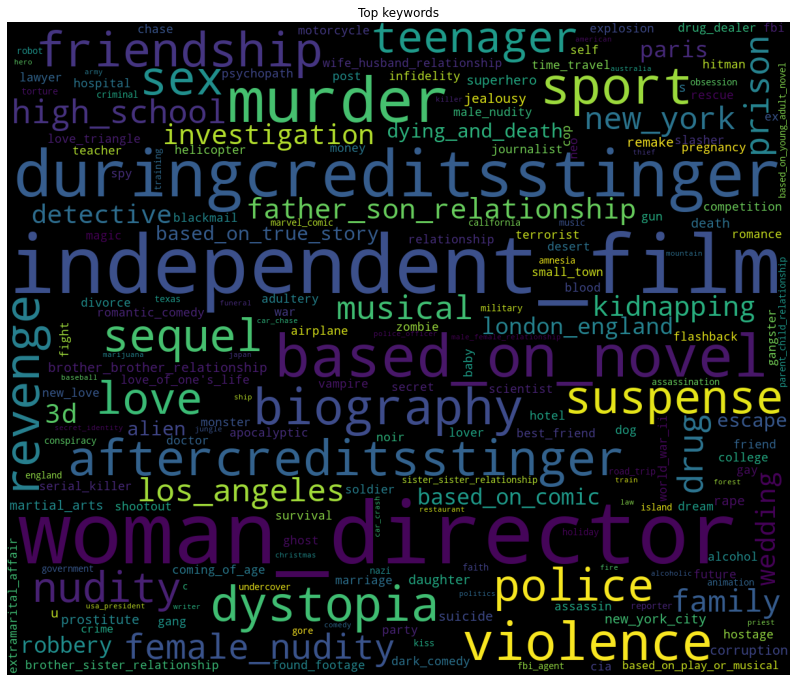

In [2133]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

### Test set

In this task we were already provided with a test-set.

In [2134]:
X_test = test.drop("id", axis=1)
X_test.head()

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,genres_list,num_genres
0,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,...,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...","[Adventure, Animation, Family, Fantasy]",4
1,{},88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,...,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de...","[Horror, Science Fiction]",2
2,{},0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,...,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de...","[Comedy, Romance]",2
3,{},6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,...,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de...","[Drama, War, Mystery]",3
4,{},2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,...,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de...","[History, Documentary]",2


In [2135]:
X_test.describe()

,budget,popularity,runtime,num_genres
count,4.398000e+03,4398.000000,4394.000000,4398.000000
mean,2.264929e+07,8.550230,107.622212,2.493633
std,3.689991e+07,12.209014,21.058290,1.114068
min,0.000000e+00,0.000001,0.000000,1.000000
25%,0.000000e+00,3.895186,94.000000,2.000000
50%,7.450000e+06,7.482241,104.000000,2.000000
75%,2.800000e+07,10.938524,118.000000,3.000000
max,2.600000e+08,547.488298,320.000000,8.000000


In [2136]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  4398 non-null   object 
 1   budget                 4398 non-null   int64  
 2   genres                 4398 non-null   object 
 3   homepage               1420 non-null   object 
 4   imdb_id                4398 non-null   object 
 5   original_language      4398 non-null   object 
 6   original_title         4398 non-null   object 
 7   overview               4384 non-null   object 
 8   popularity             4398 non-null   float64
 9   poster_path            4397 non-null   object 
 10  production_companies   4398 non-null   object 
 11  production_countries   4398 non-null   object 
 12  release_date           4397 non-null   object 
 13  runtime                4394 non-null   float64
 14  spoken_languages       4398 non-null   object 
 15  stat

Observation: few NaN

In [2137]:
len(test)

4398

In [2138]:
splitDayMonthYear(X_test)
X_test = X_test.drop(['release_date','release_day', 'release_month', 'release_dayofweek'], axis=1)

In [2139]:
#X_test['release_year']=np.where(X_test['release_year']> 2018, X_test['release_year']-100, X_test['release_year'])

In [2140]:
X_test = X_test.drop(['homepage', 'imdb_id', 'overview',
                     'original_title', 'poster_path','genres', 'genres_list',
                     'production_companies', 'production_countries',
                     'spoken_languages', 'status', 'tagline', 'title',
                     'Keywords', 'cast', 'crew', ],axis=1)

In [2141]:
X_test.head()

,belongs_to_collection,budget,original_language,popularity,runtime,num_genres,release_year
0,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,ja,3.851534,90.0,4,2007
1,{},88000,en,3.559789,65.0,2,1958
2,{},0,en,8.085194,100.0,2,1997
3,{},6800000,fr,8.596012,130.0,3,2010
4,{},2000000,en,3.217680,92.0,2,2005


In [2142]:
X_test["belongs_to_collection"] = np.where(pd.notnull(X_test["belongs_to_collection"]), 1, 0)

In [2143]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  4398 non-null   int64  
 1   budget                 4398 non-null   int64  
 2   original_language      4398 non-null   object 
 3   popularity             4398 non-null   float64
 4   runtime                4394 non-null   float64
 5   num_genres             4398 non-null   int64  
 6   release_year           4398 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 240.6+ KB


# Handeling text

Most of the provided values are not numeric, therefore it is important to make all of the objects numeric

In [2144]:
#X.head()

In [2145]:
#from sklearn.impute import SimpleImputer

#imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')                                                                                

In [2146]:
#imputer1 = SimpleImputer(missing_values = np.nan, strategy = 'median')
#X.runtime = imputer1.fit_transform(X["runtime"].values.reshape(-1,1))[:,0]

In [2147]:
#X.info() 

## Pipelines

In [2148]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [2149]:
X = X.drop([ "title", "imdb_id", "original_title", 'genres', 'genres_list',
            "status", "revenue", "spoken_languages"], axis =1)

In [2150]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  3000 non-null   int64  
 1   budget                 3000 non-null   int64  
 2   original_language      3000 non-null   object 
 3   popularity             3000 non-null   float64
 4   runtime                2998 non-null   float64
 5   num_genres             3000 non-null   int64  
 6   release_year           3000 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 164.2+ KB


In [2151]:
#Because it is very few films that the runtime is missing, the misssing ones are filled with 
X['runtime']=X['runtime'].fillna(X['runtime'].mean())

In [2152]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  3000 non-null   int64  
 1   budget                 3000 non-null   int64  
 2   original_language      3000 non-null   object 
 3   popularity             3000 non-null   float64
 4   runtime                3000 non-null   float64
 5   num_genres             3000 non-null   int64  
 6   release_year           3000 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 164.2+ KB


In [2153]:
X_numbers = X[['belongs_to_collection','budget', 'popularity', 
               'runtime', 'release_year','num_genres']]

num_pipeline = Pipeline([
                ['imputer', SimpleImputer(strategy="median")],
                ['std_scaler', StandardScaler() ],                       
  ])
X_numbers_tr = num_pipeline.fit_transform(X_numbers)
X_numbers_tr

array([[ 1.99170465, -0.23045256, -0.15599768, -0.67299251,  0.99132711,
        -1.35353959],
       [ 1.99170465,  0.47187212, -0.01771439,  0.23299381,  0.27800218,
         1.34275442],
       [-0.50208247, -0.51948618,  4.61384865, -0.12940071,  0.92647939,
        -1.35353959],
       ...,
       [-0.50208247,  1.14718432,  0.49736238,  0.55008903, -0.24077959,
         1.34275442],
       [-0.50208247,  0.5258971 ,  0.6000891 , -0.80889046,  0.27800218,
        -0.45477492],
       [-0.50208247,  0.33680969,  0.16929745, -0.0841014 ,  0.73193622,
         0.44398975]])

In [2154]:
print(X.isnull().sum())

belongs_to_collection    0
budget                   0
original_language        0
popularity               0
runtime                  0
num_genres               0
release_year             0
dtype: int64


In [2155]:
X_cat = X[['original_language']]

X_cat_attribs = list(X_cat)
X_numbers_attribs = list(X_numbers)

full_pipeline = ColumnTransformer([
    ["num", num_pipeline,X_numbers_attribs],
    ["cat", OneHotEncoder(handle_unknown = 'ignore'), X_cat_attribs]
])

X_prepared = full_pipeline.fit_transform(X)

In [2156]:
X_prepared

<3000x42 sparse matrix of type '<class 'numpy.float64'>'
	with 20998 stored elements in Compressed Sparse Row format>

In [2157]:
#MODEL_DIR = NB_DIR/'filmApp'/'app'/'models'

In [2158]:
#joblib.dump(full_pipeline, 'pip.joblib')
#dump(rf, MODEL_DIR/'pipeline.joblib', compress = 1)

# Select a model and train it

In [2159]:
#Making a function to display score value
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

### Linear regression model

In [2160]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2161]:
y = train["revenue"].copy()
lin_reg = LinearRegression()
lin_reg.fit(X_prepared, y)

LinearRegression()

In [2162]:
some_data = X.iloc[:5]
some_labels = y.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 8.62609578e+07  1.50023052e+08  1.46911506e+08  1.18024276e+06
 -1.23171432e+07]


In [2163]:
print("Labels:", list(some_labels))

Labels: [12314651, 95149435, 13092000, 16000000, 3923970]


In [2164]:
lin_scores = cross_val_score(lin_reg, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [84722403.76406276 85147102.69084056 91532137.81951873 81040794.83236969
 75023051.82556982 95816012.71758811 69056521.89245664 80160316.38795212
 86432343.93635888 78935756.20109859]
Mean: 82786644.2067816
Standard deviation: 7364935.233034792


8 millions in standard deviation.

### Decision Tree Regressor

In [2165]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()

In [2166]:
#Finding cross_val_score
scores = cross_val_score(tree_reg, 
                         X_prepared, 
                         y, 
                         scoring="neg_mean_squared_error", 
                         cv=10)
tree_rmse_scores = np.sqrt(-scores)

#Prints the tree rmse scores
display_scores(tree_rmse_scores)

Scores: [9.22705765e+07 8.98913590e+07 1.24587239e+08 1.00904939e+08
 1.13687613e+08 1.16248204e+08 1.09000724e+08 1.38600104e+08
 9.64344773e+07 9.54896920e+07]
Mean: 107711492.81197543
Standard deviation: 14926487.950165464


12 millions in standard deviation.

### Random Forest

In [2167]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10)

In [2168]:
#Finding cross-val-score
scores = cross_val_score(rf, X_prepared, y, 
                         scoring="neg_mean_squared_error", cv=10)
tree_mase_scores = np.sqrt(-scores)

In [2169]:
forest_xmae_scores = np.sqrt(-scores)
display_scores(forest_xmae_scores)

Scores: [73931856.88996518 73722630.04158612 99427115.51854187 81785272.55405141
 76077257.20346682 96632457.99650227 68320192.41697428 89018355.02442266
 84022934.19605549 75486223.41280791]
Mean: 81842429.5254374
Standard deviation: 9844875.141416071


8,5 millions in standard deviation.

In [2170]:
rf.fit(X_prepared, y)

RandomForestRegressor(n_estimators=10)

# Fine-tune our model

### Grid Search with Random Forest

In [2171]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3, 10, 30], 
               'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 
               'n_estimators': [3, 10], 
               'max_features': [2, 3, 4]},]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True) 
grid_search.fit(X_prepared, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [2172]:
# Show params for best results
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [2173]:
model = grid_search.best_estimator_
model

RandomForestRegressor(max_features=6, n_estimators=30)

In [2174]:
model_scores = cross_val_score(model, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
model_rmse_scores = np.sqrt(-model_scores)

display_scores(model_rmse_scores)

Scores: [7.29746204e+07 7.12165362e+07 1.04378516e+08 7.43763633e+07
 7.12730778e+07 9.37707554e+07 5.76762300e+07 7.83448305e+07
 8.11725858e+07 6.84649804e+07]
Mean: 77364849.59929462
Standard deviation: 12586966.091194483


Now with Grid Search of the RandomForestRegression the standard deviation is 10,5 millions.

# Submission

## Present your solution

The best model was the randomForest.

### Predict

In [2175]:
X.head(10)

,belongs_to_collection,budget,original_language,popularity,runtime,num_genres,release_year
0,1,14000000,en,6.575393,93.0,1,2015
1,1,40000000,en,8.248895,113.0,4,2004
2,0,3300000,en,64.299990,105.0,1,2014
3,0,1200000,hi,3.174936,122.0,2,2012
4,0,0,ko,1.148070,118.0,2,2009
5,0,8000000,en,0.743274,83.0,3,1987
6,0,14000000,en,7.286477,92.0,2,2012
7,0,0,en,1.949044,84.0,1,2004
8,1,0,en,6.902423,100.0,5,1996
9,0,6000000,en,4.672036,91.0,2,2003


In [2176]:
X_test.head(10)

,belongs_to_collection,budget,original_language,popularity,runtime,num_genres,release_year
0,1,0,ja,3.851534,90.0,4,2007
1,1,88000,en,3.559789,65.0,2,1958
2,1,0,en,8.085194,100.0,2,1997
3,1,6800000,fr,8.596012,130.0,3,2010
4,1,2000000,en,3.217680,92.0,2,2005
5,1,0,en,8.679350,121.0,2,1996
6,1,0,de,4.898882,119.0,3,2010
7,1,30000000,en,7.023414,77.0,2,2000
8,1,16500000,en,7.829737,120.0,2,2007
9,1,90000000,en,17.547693,92.0,3,1999


In [2177]:
X_test_prepared = full_pipeline.fit_transform(X_test)

In [2178]:
X_test_prepared

<4398x45 sparse matrix of type '<class 'numpy.float64'>'
	with 26388 stored elements in Compressed Sparse Row format>

In [2179]:
pred = rf.predict(X_test_prepared)

ValueError: Number of features of the model must match the input. Model n_features is 42 and input n_features is 45 

## Export trained model

We used joblib to export this model:

In [ ]:
#MODEL_DIR = NB_DIR

In [ ]:
#dump(rf, MODEL_DIR/'filmAppmodel.joblib', compress = 6)